# Setup

In [1]:
import tensorflow as tf
#from tf.keras.models import Sequential
#from tf.keras.layers import Dense
import os
import io

tf.__version__

'2.12.0'

In [2]:
!wget https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py

--2023-05-02 08:56:04--  https://raw.githubusercontent.com/rahulrajpr/references/main/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25018 (24K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  24.43K  --.-KB/s    in 0.001s  

2023-05-02 08:56:05 (16.1 MB/s) - ‘helper_functions.py’ saved [25018/25018]



In [3]:
!pip install split_folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Download Data

In [4]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip

--2023-05-02 08:56:10--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 203415 (199K) [application/x-httpd-php]
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z 100%[===================>] 198.65K  --.-KB/s    in 0.04s   

2023-05-02 08:56:10 (5.19 MB/s) - ‘smsspamcollection.zip’ saved [203415/203415]



In [5]:
from helper_functions import unzip_untar_data

In [6]:
unzip_untar_data('smsspamcollection.zip')

File extension : .zip
File extracting.......
Completed successfully


In [7]:
with open('/content/SMSSpamCollection','r') as f:
  content = f.read()

In [8]:
lines = content.strip().split('\n')
lines[0]

'ham\tGo until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

# Pre-Process Data

In [9]:
spam, message = [], []

for line in lines:
  s,m = tuple(line.split('\t'))
  spam.append(s)
  message.append(m)

In [10]:
spam = [1 if x.strip().lower() == 'spam' else 0 for x in spam]
spam[:3]

[0, 0, 1]

In [11]:
message[:3], spam[:3]

(['Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...',
  'Ok lar... Joking wif u oni...',
  "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"],
 [0, 0, 1])

# Data Normalization

Convert into a dataframe

In [12]:
import pandas as pd 

In [13]:
df = pd.DataFrame({'spam':spam,
                          'message':message})
df.head()

,spam,message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


Define functions for extracting the features

In [14]:
import re

# Normalization functions

def message_length(x):
  # returns total number of characters
  return len(x)

def num_capitals(x):
  _, count = re.subn(r'[A-Z]', '', x) # only works in english
  return count

def num_punctuation(x):
  _, count = re.subn(r'\W', '', x)
  return count

In [15]:
df['capitals'] = df['message'].apply(num_capitals)
df['punctuation'] = df['message'].apply(num_punctuation)
df['length'] = df['message'].apply(message_length)

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   spam         5574 non-null   int64 
 1   message      5574 non-null   object
 2   capitals     5574 non-null   int64 
 3   punctuation  5574 non-null   int64 
 4   length       5574 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 217.9+ KB


### Split the dataset into train and test

In [17]:
X = df.drop(columns = ['spam','message'], axis = 1)
y = df['spam']

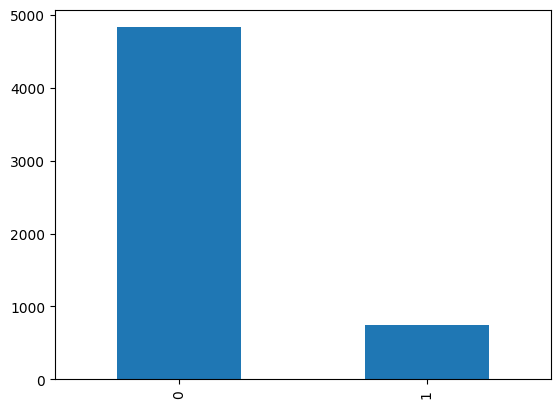

In [18]:
y.value_counts().plot(kind = 'bar');

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 42, stratify = y)

In [21]:
X_train.shape, y_train.shape, X_test.shape,y_test.shape

((4459, 3), (4459,), (1115, 3), (1115,))

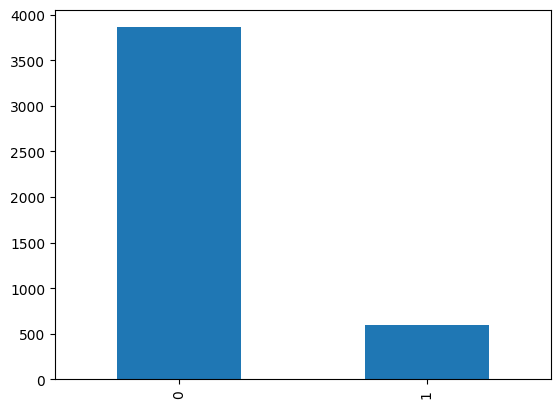

In [22]:
y_train.value_counts().plot(kind= 'bar');

In [23]:
y_train.shape, y_test.shape

((4459,), (1115,))

### Create a data pipeline

In [24]:
def create_datapipeline(X_train,y_train, X_test, y_test):
  
  y_train_onehot = tf.one_hot(y_train, depth = 2)
  y_test_onehot = tf.one_hot(y_test, depth = 2)

  train_ds = tf.data.Dataset.from_tensor_slices((X_train,y_train_onehot))
  val_ds = tf.data.Dataset.from_tensor_slices((X_test,y_test_onehot))

  train_ds = train_ds.shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
  val_ds = val_ds.batch(32).prefetch(tf.data.AUTOTUNE)

  return train_ds, val_ds

In [25]:
train_ds,val_ds = create_datapipeline(X_train,y_train, X_test, y_test)
train_ds,val_ds

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 3), dtype=tf.int64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>)

# Model 1 :

Features 

* capitals
* punctuations
* length

In [26]:
from tensorflow.keras import layers

In [27]:
train_ds.element_spec

(TensorSpec(shape=(None, 3), dtype=tf.int64, name=None),
 TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))

In [28]:
def create_model(input_shape, neurons, model_name):

  inputs = tf.keras.Input(shape = input_shape, dtype=tf.int64, name='input_layer')
  
  x = layers.Dense(units = neurons, activation='relu')(inputs)
  outputs = layers.Dense(units=2, activation='sigmoid')(x)

  model = tf.keras.Model(inputs, outputs, name = model_name)

  model.compile(loss=tf.keras.losses.binary_crossentropy,
                  optimizer=tf.keras.optimizers.Adam(),
                  metrics=['accuracy'])
  print('\nModel_summary\n')
  print(model.summary())
  return model

In [29]:
model_1 = create_model(input_shape = (3,), neurons = 10, model_name = 'model_1')


Model_summary

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 10)                40        
                                                                 
 dense_1 (Dense)             (None, 2)                 22        
                                                                 
Total params: 62
Trainable params: 62
Non-trainable params: 0
_________________________________________________________________
None


In [30]:
history_1 = model_1.fit(train_ds, epochs=10, steps_per_epoch = len(train_ds),validation_data = val_ds)

Epoch 1/10
140/140 [==============================] - 1s 3ms/step - loss: 1.7319 - accuracy: 0.6362 - val_loss: 0.8617 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 0s 2ms/step - loss: 0.7268 - accuracy: 0.8659 - val_loss: 0.6549 - val_accuracy: 0.8664
Epoch 3/10
140/140 [==============================] - 0s 2ms/step - loss: 0.6092 - accuracy: 0.8672 - val_loss: 0.5974 - val_accuracy: 0.8825
Epoch 4/10
140/140 [==============================] - 0s 2ms/step - loss: 0.5322 - accuracy: 0.8697 - val_loss: 0.4905 - val_accuracy: 0.8717
Epoch 5/10
140/140 [==============================] - 0s 3ms/step - loss: 0.4632 - accuracy: 0.8751 - val_loss: 0.4291 - val_accuracy: 0.8816
Epoch 6/10
140/140 [==============================] - 0s 2ms/step - loss: 0.4129 - accuracy: 0.8838 - val_loss: 0.3926 - val_accuracy: 0.9040
Epoch 7/10
140/140 [==============================] - 0s 2ms/step - loss: 0.3764 - accuracy: 0.8915 - val_loss: 0.3550 - val_accuracy: 0.9013
Epoch 

In [31]:
model_1.evaluate(val_ds)

35/35 [==============================] - 0s 1ms/step - loss: 0.2970 - accuracy: 0.9085


[0.29700756072998047, 0.9085201621055603]

In [32]:
from helper_functions import calculate_results

In [33]:
import numpy as np
def show_results(model,val_ds,y_true = y_test):
  pred_prob = model.predict(val_ds)
  pred = np.argmax(pred_prob, axis = 1)
  results = calculate_results(y_test, pred)
  return results

In [34]:
results_1 = show_results(model = model_1,val_ds = val_ds, y_true = y_test)
results_1

35/35 [==============================] - 0s 2ms/step


{'accuracy': 0.9085201793721973,
 'precision': 0.9005012018037736,
 'recall': 0.9085201793721973,
 'f1': 0.8970188914753628}

# Model 2:

* Tokenization
* Stop Word Removal
* Word Count

# Tokenization and Stop Word Removal

# Adding Word Count Feature 

In [35]:
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [36]:
def count_words(x):
  tokens = word_tokenize(x)
  count = len(tokens)
  return count

In [37]:
df['num_words'] = df['message'].apply(lambda x : count_words(x))

In [38]:
X = df.drop(columns = ['spam','message'], axis = 1)
y = df['spam']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 42, stratify = y)

In [39]:
train_ds_2,val_ds_2 = create_datapipeline(X_train,y_train, X_test, y_test)
train_ds_2,val_ds_2

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.int64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.int64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>)

In [40]:
model_2 = create_model(input_shape = (4,), neurons = 10, model_name = 'model_2')


Model_summary

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4)]               0         
                                                                 
 dense_2 (Dense)             (None, 10)                50        
                                                                 
 dense_3 (Dense)             (None, 2)                 22        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
None


In [41]:
history_2 = model_2.fit(train_ds_2, epochs=10, steps_per_epoch = len(train_ds_2),validation_data = val_ds_2)

Epoch 1/10
140/140 [==============================] - 2s 7ms/step - loss: 2.1048 - accuracy: 0.8453 - val_loss: 0.8170 - val_accuracy: 0.8081
Epoch 2/10
140/140 [==============================] - 1s 5ms/step - loss: 0.7026 - accuracy: 0.8426 - val_loss: 0.6271 - val_accuracy: 0.8484
Epoch 3/10
140/140 [==============================] - 1s 4ms/step - loss: 0.4998 - accuracy: 0.8753 - val_loss: 0.4187 - val_accuracy: 0.8987
Epoch 4/10
140/140 [==============================] - 1s 5ms/step - loss: 0.3784 - accuracy: 0.9049 - val_loss: 0.3393 - val_accuracy: 0.9058
Epoch 5/10
140/140 [==============================] - 1s 5ms/step - loss: 0.3193 - accuracy: 0.9159 - val_loss: 0.2951 - val_accuracy: 0.9238
Epoch 6/10
140/140 [==============================] - 1s 4ms/step - loss: 0.2800 - accuracy: 0.9269 - val_loss: 0.2637 - val_accuracy: 0.9256
Epoch 7/10
140/140 [==============================] - 1s 4ms/step - loss: 0.2575 - accuracy: 0.9307 - val_loss: 0.2441 - val_accuracy: 0.9318
Epoch 

In [42]:
results_2 = show_results(model = model_2,val_ds = val_ds_2, y_true = y_test)
results_2

35/35 [==============================] - 0s 4ms/step


{'accuracy': 0.9282511210762332,
 'precision': 0.9239086394225585,
 'recall': 0.9282511210762332,
 'f1': 0.9228354747989612}

## Stop Word Removal

In [43]:
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [44]:
stop_words = set(stopwords.words('english'))

In [45]:
def count_excl_stop_words(x):
  tokens = word_tokenize(x)
  words_ex_stops = [0 if x in stop_words else 1 for x in tokens]
  word_count = sum(words_ex_stops)
  return word_count

In [46]:
df['num_words'] = df['message'].apply(lambda x : count_excl_stop_words(x))
df['num_words']

0       20
1        8
2       32
3       11
4       10
        ..
5569    27
5570     8
5571     9
5572    16
5573     5
Name: num_words, Length: 5574, dtype: int64

In [47]:
X = df.drop(columns = ['spam','message'], axis = 1)
y = df['spam']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 42, stratify = y)

In [48]:
train_ds_3,val_ds_3 = create_datapipeline(X_train,y_train, X_test, y_test)
train_ds_3,val_ds_3

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.int64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 4), dtype=tf.int64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>)

In [49]:
model_3 = create_model(input_shape = (4,), neurons = 10, model_name = 'model_3')


Model_summary

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 4)]               0         
                                                                 
 dense_4 (Dense)             (None, 10)                50        
                                                                 
 dense_5 (Dense)             (None, 2)                 22        
                                                                 
Total params: 72
Trainable params: 72
Non-trainable params: 0
_________________________________________________________________
None


In [50]:
history_3 = model_3.fit(train_ds_3, epochs=10, steps_per_epoch = len(train_ds_3),validation_data = val_ds_3)

Epoch 1/10
140/140 [==============================] - 2s 5ms/step - loss: 7.3766 - accuracy: 0.8652 - val_loss: 3.1566 - val_accuracy: 0.8637
Epoch 2/10
140/140 [==============================] - 1s 6ms/step - loss: 1.5430 - accuracy: 0.8262 - val_loss: 0.7514 - val_accuracy: 0.7614
Epoch 3/10
140/140 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.8237 - val_loss: 0.5810 - val_accuracy: 0.8538
Epoch 4/10
140/140 [==============================] - 1s 4ms/step - loss: 0.5355 - accuracy: 0.8850 - val_loss: 0.4908 - val_accuracy: 0.8861
Epoch 5/10
140/140 [==============================] - 1s 4ms/step - loss: 0.4660 - accuracy: 0.8989 - val_loss: 0.4229 - val_accuracy: 0.8969
Epoch 6/10
140/140 [==============================] - 1s 5ms/step - loss: 0.3681 - accuracy: 0.9107 - val_loss: 0.3413 - val_accuracy: 0.9247
Epoch 7/10
140/140 [==============================] - 1s 5ms/step - loss: 0.3181 - accuracy: 0.9146 - val_loss: 0.2962 - val_accuracy: 0.9157
Epoch 

In [51]:
results_3 = show_results(model = model_3,val_ds = val_ds_3, y_true = y_test)
results_3

35/35 [==============================] - 0s 3ms/step


{'accuracy': 0.9201793721973094,
 'precision': 0.9146891107476427,
 'recall': 0.9201793721973094,
 'f1': 0.9155782616275158}

# Model 4 

## POS Based Features

In [52]:
import nltk
nltk.download('averaged_perceptron_tagger')
from nltk import pos_tag
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [53]:
def pos_tagging(x):
  tokens = word_tokenize(x)
  pos = pos_tag(tokens)
  pos = [x[1] for x in pos]
  pos = pd.Series(pos).value_counts().to_dict()
  return pos

In [54]:
pos_series = df['message'].apply(lambda x : pos_tagging(x))
pos_series.head()

0    {'NN': 7, 'NNP': 3, 'JJ': 3, 'RB': 3, 'IN': 2,...
1       {'NNP': 2, 'NN': 2, ':': 2, 'WRB': 1, 'JJ': 1}
2    {'NN': 7, 'NNP': 6, 'CD': 5, 'JJ': 4, 'TO': 3,...
3    {'VBP': 3, 'RB': 3, 'JJ': 2, ':': 2, 'NNS': 1,...
4    {'PRP': 3, 'RB': 3, 'VB': 2, 'VBZ': 2, 'NNP': ...
Name: message, dtype: object

In [55]:
pos_count = pd.json_normalize(pos_series).fillna(0)
pos_count.head()

,NN,NNP,JJ,RB,IN,:,",",FW,EX,VBD,...,PDT,#,'',``,NNPS,RBR,RBS,SYM,WP$,LS
0,7.0,3.0,3.0,3.0,2.0,2.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2.0,2.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,7.0,6.0,4.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,2.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,3.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
df_pos = pd.concat([df,pos_count], axis = 1)
df_pos

,spam,message,capitals,punctuation,length,num_words,NN,NNP,JJ,RB,...,PDT,#,'',``,NNPS,RBR,RBS,SYM,WP$,LS
0,0,"Go until jurong point, crazy.. Available only ...",3,28,111,20,7.0,3.0,3.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,Ok lar... Joking wif u oni...,2,11,29,8,2.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,10,33,155,32,7.0,6.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,U dun say so early hor... U c already then say...,2,16,49,11,1.0,1.0,2.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,"Nah I don't think he goes to usf, he lives aro...",2,14,61,10,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,1,This is the 2nd time we have tried 2 contact u...,9,38,160,27,6.0,3.0,4.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0,Will ü b going to esplanade fr home?,1,8,36,8,3.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5571,0,"Pity, * was in mood for that. So...any other s...",2,16,57,9,3.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5572,0,The guy did some bitching but I acted like i'd...,2,26,125,16,5.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
X = df_pos.drop(columns = ['spam','message'], axis = 1)
y = df_pos['spam']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 42, stratify = y)

In [58]:
train_ds_4,val_ds_4 = create_datapipeline(X_train,y_train, X_test, y_test)
train_ds_4,val_ds_4

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 49), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 49), dtype=tf.float64, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>)

In [59]:
sh = X_train.shape[1]
sh

49

In [60]:
model_4 = create_model(input_shape = (sh,), neurons = 10, model_name = 'model_4')


Model_summary

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 49)]              0         
                                                                 
 dense_6 (Dense)             (None, 10)                500       
                                                                 
 dense_7 (Dense)             (None, 2)                 22        
                                                                 
Total params: 522
Trainable params: 522
Non-trainable params: 0
_________________________________________________________________
None


In [61]:
history_4 = model_4.fit(train_ds_4, epochs=10, steps_per_epoch = len(train_ds_4),validation_data = val_ds_4)

Epoch 1/10
140/140 [==============================] - 1s 3ms/step - loss: 0.9814 - accuracy: 0.8634 - val_loss: 0.4580 - val_accuracy: 0.8655
Epoch 2/10
140/140 [==============================] - 0s 2ms/step - loss: 0.3517 - accuracy: 0.9119 - val_loss: 0.3065 - val_accuracy: 0.9211
Epoch 3/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2531 - accuracy: 0.9372 - val_loss: 0.2393 - val_accuracy: 0.9381
Epoch 4/10
140/140 [==============================] - 0s 2ms/step - loss: 0.2044 - accuracy: 0.9491 - val_loss: 0.2023 - val_accuracy: 0.9426
Epoch 5/10
140/140 [==============================] - 0s 2ms/step - loss: 0.1743 - accuracy: 0.9583 - val_loss: 0.1776 - val_accuracy: 0.9507
Epoch 6/10
140/140 [==============================] - 0s 2ms/step - loss: 0.1556 - accuracy: 0.9617 - val_loss: 0.1612 - val_accuracy: 0.9552
Epoch 7/10
140/140 [==============================] - 0s 2ms/step - loss: 0.1413 - accuracy: 0.9630 - val_loss: 0.1481 - val_accuracy: 0.9596
Epoch 

In [62]:
results_4 = show_results(model = model_4,val_ds = val_ds_4, y_true = y_test)
results_4

35/35 [==============================] - 0s 1ms/step


{'accuracy': 0.9659192825112107,
 'precision': 0.9651363086340664,
 'recall': 0.9659192825112107,
 'f1': 0.9652018573355804}

# Lemmatization

In [63]:
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to /root/nltk_data...


In [64]:
lemmatizer = WordNetLemmatizer()

In [65]:
def lemmatize_sentence(x):
  tokens = word_tokenize(x)
  lemma = ' '.join([lemmatizer.lemmatize(x) for x in tokens])
  return lemma

In [66]:
df['message'] = df['message'].apply(lambda x :lemmatize_sentence(x))
df['message']

0       Go until jurong point , crazy .. Available onl...
1                         Ok lar ... Joking wif u oni ...
2       Free entry in 2 a wkly comp to win FA Cup fina...
3       U dun say so early hor ... U c already then sa...
4       Nah I do n't think he go to usf , he life arou...
                              ...                        
5569    This is the 2nd time we have tried 2 contact u...
5570                Will ü b going to esplanade fr home ?
5571    Pity , * wa in mood for that . So ... any othe...
5572    The guy did some bitching but I acted like i '...
5573                           Rofl . Its true to it name
Name: message, Length: 5574, dtype: object

# TF-IDF Based Model


## Count Vectorization

In [67]:
corpus = df['message'].values
corpus

array(['Go until jurong point , crazy .. Available only in bugis n great world la e buffet ... Cine there got amore wat ...',
       'Ok lar ... Joking wif u oni ...',
       "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005 . Text FA to 87121 to receive entry question ( std txt rate ) T & C 's apply 08452810075over18 's",
       ...,
       'Pity , * wa in mood for that . So ... any other suggestion ?',
       "The guy did some bitching but I acted like i 'd be interested in buying something else next week and he gave it to u for free",
       'Rofl . Its true to it name'], dtype=object)

In [68]:
import sklearn
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(corpus)
vectorizer.get_feature_names_out()

array(['00', '000', '000pes', ..., 'èn', 'ú1', '〨ud'], dtype=object)

In [69]:
X = X.toarray()

In [70]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity(X)

array([[1.        , 0.        , 0.03874921, ..., 0.0745356 , 0.04914732,
        0.        ],
       [0.        , 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.03874921, 0.        , 1.        , ..., 0.05198752, 0.17139779,
        0.20134682],
       ...,
       [0.0745356 , 0.        , 0.05198752, ..., 1.        , 0.13187609,
        0.        ],
       [0.04914732, 0.        , 0.17139779, ..., 0.13187609, 1.        ,
        0.17025131],
       [0.        , 0.        , 0.20134682, ..., 0.        , 0.17025131,
        1.        ]])

In [71]:
cosine_similarity(X).shape

(5574, 5574)

In [72]:
query = vectorizer.transform(["apple and bananas"])
cosine_similarity(X, query)

array([[0.        ],
       [0.        ],
       [0.        ],
       ...,
       [0.        ],
       [0.20851441],
       [0.        ]])

## TF-IDF Vectorization

In [73]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer(smooth_idf=False)
tfidf = transformer.fit_transform(X)

pd.DataFrame(tfidf.toarray(), 
             columns=vectorizer.get_feature_names_out())

,00,000,000pes,008704050406,0089,0121,01223585236,01223585334,0125698789,02,...,zhong,zindgi,zoe,zogtorius,zoom,zouk,zyada,èn,ú1,〨ud
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5569,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5570,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5572,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [98]:
X = df['message'].values
y = df['spam'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size = 0.8,random_state = 42, stratify = y)

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

tfidf = TfidfVectorizer(binary=True)
X_train = tfidf.fit_transform(X_train).astype('float32')
X_test = tfidf.transform(X_test).astype('float32')

In [100]:
X_train = X_train.toarray()
X_test = X_test.toarray()

In [101]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4459, 7393), (1115, 7393), (4459,), (1115,))

In [103]:
train_ds_5,val_ds_5 = create_datapipeline(X_train,y_train, X_test, y_test)
train_ds_5,val_ds_5

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7393), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7393), dtype=tf.float32, name=None), TensorSpec(shape=(None, 2), dtype=tf.float32, name=None))>)

In [104]:
sh = X_train.shape[1]
sh

7393

In [105]:
model_5 = create_model(input_shape = (sh,), neurons = 10, model_name = 'model_5')


Model_summary

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 7393)]            0         
                                                                 
 dense_8 (Dense)             (None, 10)                73940     
                                                                 
 dense_9 (Dense)             (None, 2)                 22        
                                                                 
Total params: 73,962
Trainable params: 73,962
Non-trainable params: 0
_________________________________________________________________
None


In [106]:
history_5 = model_5.fit(train_ds_5, epochs=10, steps_per_epoch = len(train_ds_5),validation_data = val_ds_5)

Epoch 1/10
140/140 [==============================] - 3s 11ms/step - loss: 0.6240 - accuracy: 0.8657 - val_loss: 0.5427 - val_accuracy: 0.8664
Epoch 2/10
140/140 [==============================] - 1s 6ms/step - loss: 0.4787 - accuracy: 0.8659 - val_loss: 0.4289 - val_accuracy: 0.8664
Epoch 3/10
140/140 [==============================] - 1s 6ms/step - loss: 0.4110 - accuracy: 0.8659 - val_loss: 0.3991 - val_accuracy: 0.8664
Epoch 4/10
140/140 [==============================] - 1s 6ms/step - loss: 0.3965 - accuracy: 0.8659 - val_loss: 0.3939 - val_accuracy: 0.8664
Epoch 5/10
140/140 [==============================] - 1s 6ms/step - loss: 0.3943 - accuracy: 0.8659 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 6/10
140/140 [==============================] - 1s 6ms/step - loss: 0.3941 - accuracy: 0.8659 - val_loss: 0.3930 - val_accuracy: 0.8664
Epoch 7/10
140/140 [==============================] - 1s 5ms/step - loss: 0.3938 - accuracy: 0.8659 - val_loss: 0.3930 - val_accuracy: 0.8664
Epoch

In [107]:
results_5 = show_results(model = model_5,val_ds = val_ds_5, y_true = y_test)
results_5

35/35 [==============================] - 0s 7ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


{'accuracy': 0.8663677130044843,
 'precision': 0.7505930141366205,
 'recall': 0.8663677130044843,
 'f1': 0.8043356182242498}

# Word Vectors

In [ ]:
# memory limit may be exceeded. Try deleting some objects before running this next section
# or copy this section to a different notebook.
!pip install gensim

In [ ]:
from gensim.models.word2vec import Word2Vec
import gensim.downloader as api

In [ ]:
api.info()

{'corpora': {'20-newsgroups': {'checksum': 'c92fd4f6640a86d5ba89eaad818a9891',
   'description': 'The notorious collection of approximately 20,000 newsgroup posts, partitioned (nearly) evenly across 20 different newsgroups.',
   'fields': {'data': '',
    'id': 'original id inferred from folder name',
    'set': "marker of original split (possible values 'train' and 'test')",
    'topic': 'name of topic (20 variant of possible values)'},
   'file_name': '20-newsgroups.gz',
   'file_size': 14483581,
   'license': 'not found',
   'num_records': 18846,
   'parts': 1,
   'read_more': ['http://qwone.com/~jason/20Newsgroups/'],
   'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/20-newsgroups/__init__.py',
   'record_format': 'dict'},
  '__testing_matrix-synopsis': {'checksum': '1767ac93a089b43899d54944b07d9dc5',
   'description': '[THIS IS ONLY FOR TESTING] Synopsis of the movie matrix.',
   'file_name': '__testing_matrix-synopsis.gz',
   'parts': 1,
   're

In [ ]:
model_w2v = api.load("word2vec-google-news-300")

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [ ]:
model_w2v.most_similar("cookies",topn=10)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('cookie', 0.745154082775116),
 ('oatmeal_raisin_cookies', 0.6887780427932739),
 ('oatmeal_cookies', 0.662139892578125),
 ('cookie_dough_ice_cream', 0.6520504951477051),
 ('brownies', 0.6479344964027405),
 ('homemade_cookies', 0.6476464867591858),
 ('gingerbread_cookies', 0.6461867690086365),
 ('Cookies', 0.6341644525527954),
 ('cookies_cupcakes', 0.6275068521499634),
 ('cupcakes', 0.6258294582366943)]

In [ ]:
model_w2v.doesnt_match(["USA","Canada","India","Tokyo"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


'Tokyo'

In [ ]:
king = model_w2v['king']
man = model_w2v['man']
woman = model_w2v['woman']

queen = king - man + woman  
model_w2v.similar_by_vector(queen)

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('king', 0.8449392318725586),
 ('queen', 0.7300517559051514),
 ('monarch', 0.6454660892486572),
 ('princess', 0.6156251430511475),
 ('crown_prince', 0.5818676948547363),
 ('prince', 0.5777117609977722),
 ('kings', 0.5613663792610168),
 ('sultan', 0.5376776456832886),
 ('Queen_Consort', 0.5344247817993164),
 ('queens', 0.5289887189865112)]